# Digital Earth Australia Intertidal workflow

## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
cd ..

/home/jovyan/dea_intertidal/dea-intertidal


Install additional packages directly from the requirements file

In [2]:
# pip install -r requirements.in --quiet
!pip install sunriset

In [3]:
!pip3 install "bokeh==3.2.2"

### Load packages

In [4]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datacube
from datacube.utils.geometry import Geometry

from intertidal.utils import (
    load_config,
    round_date_strings,
    export_intertidal_rasters,
    intertidal_hillshade,
)
from intertidal.elevation import load_data, load_topobathy, elevation
from intertidal.extents import extents
from intertidal.exposure import exposure
from intertidal.tidal_bias_offset import bias_offset, tidal_offset_tidelines
from dea_tools.dask import create_local_dask_cluster

## Setup


### Set analysis parameters

In [27]:
# Set study area and config
# study_area = "gulfcarpentaria1" #"pointstuart"
# config_path = "configs/dea_intertidal_config_development.yaml"
# study_area = '844'
# config_path='configs/dea_intertidal_config.yaml'

# Intertidal Elevation variables
start_date = "2018"  # Start date for analysis
end_date = "2020"  # End date for analysis
resolution = 10  # Spatial resolution used for output files
crs = "EPSG:3577"  # Coordinate Reference System (CRS) to use for output files
ndwi_thresh = 0.1  # Threshold used to identify dry/wet transition when calculating elevation
include_s2 = True  # Include Sentinel-2 data in the analysis?
include_ls = True  # Include Landsat data in the analysis?
filter_gqa = False  # Filter to remove poorly georeferenced scenes?
tide_model = "FES2014"  # Tide model to use in analysis
# tide_model_dir = "/var/share/tide_models"  # Directory containing tide model files
# tide_model = ["FES2014", "FES2012", "TPXO9-atlas-v5"]
tide_model_dir = "/gdata1/data/tide_models_clipped"

# Exposure variables
modelled_freq = "3h"  # Frequency to run tidal model e.g '30min' or '1h'

# Generate range of times covering entire period of satellite record for exposure and bias/offset calculation
all_timerange = pd.date_range(
    start=round_date_strings(start_date, round_type="start"),
    end=round_date_strings(end_date, round_type="end"),
    freq=modelled_freq,
)

#### *Optional: override study area selection using interactive map*

In [6]:
from odc.ui import select_on_a_map
from ipyleaflet import basemaps, basemap_to_tiles

# Plot interactive map to select area
basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
geom = select_on_a_map(height='600px',
                       layers=(basemap,),
                       center=(-26, 135),
                       zoom=4)
study_area = geom

Map(center=[-26, 135], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

## Intertidal workflow

### Load data

In [28]:
# Connect to datacube
dc = datacube.Datacube(app="Intertidal_workflow")

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

satellite_ds = load_data(
    dc=dc,
    study_area=study_area,
    time_range=(start_date, end_date),
    resolution=resolution,
    crs=crs,
    s2_prod="s2_nbart_ndwi" if include_s2 else None,
    ls_prod="ls_nbart_ndwi" if include_ls else None,
    config_path=config_path,
    filter_gqa=filter_gqa)[["ndwi"]]

# Load data and close dask client
satellite_ds.load()
client.close()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 62,Total memory: 477.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35571,Workers: 1
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,Total threads: 62
Started: Just now,Total memory: 477.21 GiB
Comm: tcp://127.0.0.1:37529,Total threads: 62
Dashboard: /user/claire.phillips@ga.gov.au/proxy/40513/status,Memory: 477.21 GiB
Nanny: tcp://127.0.0.1:34919,


/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


### Load optional topobathy mask
Loads a topo-bathymetric DEM for the extents of the loaded satellite data.
This is used as a coarse mask to constrain the analysis to the coastal zone, improving run time and reducing clear false positives over deep water or elevated land.

In [29]:
# Load data from GA's Australian Bathymetry and Topography Grid 2009
topobathy_ds = load_topobathy(
    dc, satellite_ds, product="ga_multi_ausbath_0", resampling="bilinear"
)

### Intertidal elevation
To run without the topobathy DEM mask, comment out `valid_mask=...`.

In [30]:
# Model elevation for each pixel
ds, ds_aux, tide_m = elevation(
    satellite_ds,
    valid_mask=topobathy_ds.height_depth > -20,
    tide_model=tide_model,
    tide_model_dir=tide_model_dir,
    config_path=config_path,
)

2023-11-15 02:55:40 INFO Modelling tide heights for each pixel


Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014 in parallel


100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


Reprojecting tides into original array


2023-11-15 02:56:02 INFO Masking nodata and adding tide heights to satellite data array
2023-11-15 02:56:03 INFO Flattening satellite data array and filtering to intertidal candidate pixels
2023-11-15 02:56:03 INFO Applying valid data mask to constrain study area
2023-11-15 02:56:16 INFO Running per-pixel rolling median


Reducing analysed pixels from 637179 to 7696 (1.21%)


100%|██████████| 114/114 [00:08<00:00, 13.74it/s]
2023-11-15 02:56:27 INFO Modelling intertidal elevation
2023-11-15 02:56:27 INFO Modelling intertidal uncertainty
2023-11-15 02:56:30 INFO Unflattening data back to its original spatial dimensions
2023-11-15 02:56:30 INFO Successfully completed intertidal elevation modelling


### Intertidal extents


In [31]:
## Original script call

# ds['extents'] = extents(ds_aux.ndwi_wet_freq, ds.elevation, ds_aux.ndwi_tide_corr)


In [32]:
## Script funcs for editing

import xarray as xr
import numpy as np

import datacube
from skimage.measure import label, regionprops
from skimage.morphology import (binary_erosion, disk)

def ocean_masking(ds, ocean_da, connectivity=1, dilation=None):
    """
    ## from https://github.com/GeoscienceAustralia/dea-coastlines/blob/develop/coastlines/vector.py#L188-L198
    
    Identifies ocean by selecting regions of water that overlap
    with ocean pixels. This region can be optionally dilated to
    ensure that the sub-pixel algorithm has pixels on either side
    of the water index threshold.
    Parameters:
    -----------
    ds : xarray.DataArray
        An array containing True for land pixels, and False for water.
        This can be obtained by thresholding a water index
        array (e.g. MNDWI < 0).
    ocean_da : xarray.DataArray
        A supplementary static dataset used to separate ocean waters
        from other inland water. The array should contain values of 1
        for high certainty ocean pixels, and 0 for all other pixels
        (land, inland water etc). For Australia, we use the  Geodata
        100K coastline dataset, rasterized as the "geodata_coast_100k"
        product on the DEA datacube.
    connectivity : integer, optional
        An integer passed to the 'connectivity' parameter of the
        `skimage.measure.label` function.
    dilation : integer, optional
        The number of pixels to dilate ocean pixels to ensure than
        adequate land pixels are included for subpixel waterline
        extraction. Defaults to None.
    Returns:
    --------
    ocean_mask : xarray.DataArray
        An array containing the a mask consisting of identified ocean
        pixels as True.
    """

#     # Update `ocean_da` to mask out any pixels that are land in `ds` too
#     ocean_da = ocean_da & (ds != 1)

    # First, break all time array into unique, discrete regions/blobs.
    # Fill NaN with 1 so it is treated as a background pixel
    blobs = xr.apply_ufunc(label, ds.fillna(1), 1, False, connectivity)

    # For each unique region/blob, use region properties to determine
    # whether it overlaps with a water feature from `water_mask`. If
    # it does, then it is considered to be directly connected with the
    # ocean; if not, then it is an inland waterbody.
    ocean_mask = blobs.isin(
        [i.label for i in regionprops(blobs.values, ocean_da.values) if i.max_intensity]
    )

    # Dilate mask so that we include land pixels on the inland side
    # of each shoreline to ensure contour extraction accurately
    # seperates land and water spectra
    if dilation:
        ocean_mask = xr.apply_ufunc(binary_dilation, ocean_mask, disk(dilation))

    return ocean_mask


def extents(freq,
           dem,
           corr,
           product = 'geodata_coast_100k'):
    '''
    Classify coastal ecosystems into broad classes based 
    on their respective patterns of wetting frequency,
    relationship to tidal inundation and proximity to
    the ocean.

    Parameters:
    -----------
    dem : xarray.DataArray
        An xarray.DataArray of the final intertidal DEM, generated 
        during the intertidal.elevation workflow
    freq : xarray.DataArray
        An xarray.DataArray of the NDWI frequency layer summarising the 
        frequency of wetness per pixel for any given time-series, 
        generated during the intertidal.elevation workflow
    corr : xarray.DataArray
        An xarray.DataArray of the correlation between pixel NDWI values
        and the tide-height, generated during the intertidal.elevation workflow
    ocean_da : xarray.DataArray
        A supplementary static dataset used to separate ocean waters
        from other inland water. The array should contain values of 1
        for high certainty ocean pixels, and 0 for all other pixels
        (land, inland water etc). For Australia, we use the  Geodata
        100K coastline dataset, rasterized as the "geodata_coast_100k"
        product on the DEA datacube.

    Returns:
    --------
    extents: xarray.DataArray
        A binary xarray.DataArray depicting intertidal (0), tidal-wet (1),
        nontidal-wet (2), intermittently, non-tidal wet (3) and dry (4) coastal extents.
    Notes:
    ------
    Classes are defined as follows:
    0: Dry
        Pixels with wettness `freq` < 0.05
        Includes intermittently dry pixels with wetness frequency < 0.5 and > 0.05
        and `corr` to tide > 0.1 to capture intertidal pixels buffered
        out by the `corr` threshold of 0.2
    1: Intertidal
        Frequency of pixel wetness (`freq`) is > 0.01 and < 0.99
        The correlation (`corr`) between `freq` and tide-heights is > 0.2
    2: Wet tidal
        Frequency of pixel wetness (`freq`) is > 0.95
        Includes intermittently wet pixels with `freq` > 0.5 and < 0.95,
        and `corr` to tide > 0.1. This captures intertidal pixels buffered
        out by the `corr` threshold of 0.2 (default)
        Pixels are located offshore, within 10 pixels of known ocean, as defined
        by the Geodata 100k coastline dataset (`ocean_da`)
    3: Wet nontidal
        Frequency of pixel wetness (`freq`) is > 0.95
        Includes intermittently wet pixels with `freq` > 0.5 and < 0.95,
        and `corr` to tide > 0.1. This captures intertidal pixels buffered
        out by the `corr` threshold of 0.2 (default)
        Pixels are located onshore, more than 10 pixels from known ocean, as defined
        by the Geodata 100k coastline dataset (`ocean_da`)
    4: Intermittently wet nontidal
        Pixels with wetting `freq` between 0.95 and 0.05 and
        `corr` of `freq` to tide is < 0.1    
    '''
    
    ## Connect to datacube to load `ocean_da`
    dc = datacube.Datacube(app='ocean_masking')
    
    ## Isolate intertidal class
    intertidal = freq.where(dem.notnull())

    ## Isolate non-intertidal class
    wetdry = freq.where(dem.isnull())

    ## Separate non-intertidal areas into always wet and always dry classes
    wet = wetdry.where(wetdry >= 0.99, drop=True)
    dry = wetdry.where((wetdry <= 0.01), drop=True)

    ## Identify intermittent tidal classes 
    intermittent_tidal_wet = freq.where(
                                        (wetdry < 0.99)
                                        & (wetdry >= 0.5) 
                                        & (corr > 0.1) 
                                       )

    intermittent_tidal_dry = freq.where(
                                        (wetdry < 0.5)
                                        & (wetdry > 0.01) 
                                        & (corr > 0.1) 
                                        )

    ## Identify intermittent non-tidal class
    intermittent_nontidal = freq.where(
                                       (wetdry < 0.99)
                                       & (wetdry > 0.01) 
                                       & (corr <= 0.1)
                                       )

    ## Relabel pixels in the classes. 
    ## Add intermittent tidal wet/dry to the always wet/dry classes
    dry = dry.where(dry.isnull(), 0)
    intermittent_tidal_dry = intermittent_tidal_dry.where(intermittent_tidal_dry.isnull(), 0)
    
    intertidal = intertidal.where(intertidal.isnull(), 1)
    
    wet = wet.where(wet.isnull(), 2)
    intermittent_tidal_wet = intermittent_tidal_wet.where(intermittent_tidal_wet.isnull(), 2)
        
    intermittent_nontidal = intermittent_nontidal.where(intermittent_nontidal.isnull(), 4)

    ## Combine classes
    extents = intertidal.combine_first(wet)
    extents = extents.combine_first(dry)
    extents = extents.combine_first(intermittent_tidal_wet)
    extents = extents.combine_first(intermittent_tidal_dry)
    extents = extents.combine_first(intermittent_nontidal)

    ## Separate the onshore from offshore 'always wet' class

    ## Mask all pixels in `extents` as `always_wet` or 'other'
    landwater=extents.where(extents != 1, False)

    ## Load the Geodata 100k coastline layer to use as the seawater mask

    # Load Geodata 100K coastal layer to use to separate ocean waters from
    # other inland waters. This product has values of 0 for ocean waters,
    # and values of 1 and 2 for mainland/island pixels. We extract ocean
    # pixels (value 0), then erode these by 10 pixels to ensure we only
    # use high certainty deeper water ocean regions for identifying ocean
    # pixels in our satellite imagery. If no Geodata data exists (e.g.
    # over remote ocean waters, use an all True array to represent ocean.
    try:    
        geodata_da = dc.load(product = product,
                            like=landwater.odc.geobox.compat
                          ).land.squeeze('time')
        ocean_da = xr.apply_ufunc(binary_erosion, geodata_da == 0, disk(10))
    except AttributeError:
        ocean_da = odc.geo.xr.xr_zeros(landwater.odc.geobox) == 0
    # except ValueError:  # Temporary workaround for no geodata access for tests from https://github.com/GeoscienceAustralia/dea-coastlines/blob/develop/coastlines/vector.py
    #     ocean_da = xr.apply_ufunc(binary_erosion, all_time_20==0, disk(20))

    ## Applying ocean_masking function
    ocean_mask = ocean_masking(landwater, ocean_da)

    ## distinguish wet tidal from non-tidal pixels
    wet_nontidal = extents.where((extents==2) & (ocean_mask == False))#, drop=True) ## Weird artefacts when drop=True
    wet_tidal = extents.where((extents==2) & (ocean_mask == True), drop=True)

    ## Relabel pixels
    wet_nontidal = wet_nontidal.where(wet_nontidal.isnull(), 3)
    wet_tidal = wet_tidal.where(wet_tidal.isnull(), 2)

    ## remove `wet` pixels from int_ext to replace with the tidal and non tidal wet classes
    extents = extents.where(extents != 2, np.nan)

    ## combine wet tidal and nontidal variables back into int_ext
    extents = extents.combine_first(wet_nontidal)
    extents = extents.combine_first(wet_tidal)
    
    return extents

In [33]:
ds['extents'] = extents(ds_aux.ndwi_wet_freq, ds.elevation, ds_aux.ndwi_tide_corr)

['0_Dry', '1_intertidal', '2_wet_tidal', '3_wet_nontidal', '4_intermittently_wet']


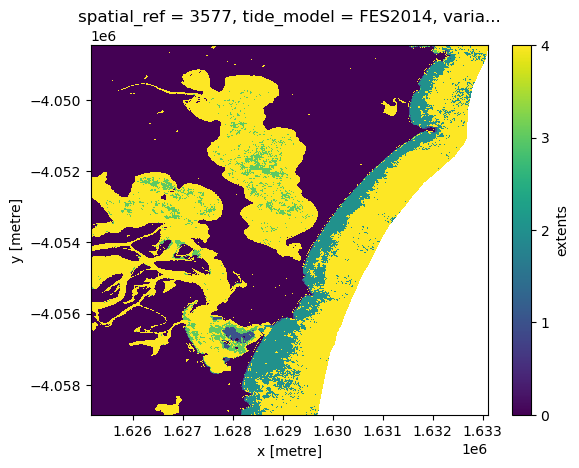

In [34]:
labels=(['0_Dry',
        '1_intertidal',
        '2_wet_tidal',
        '3_wet_nontidal',
        '4_intermittently_wet'])

ds.extents.plot(cbar_kwargs={'ticks':[0,1,2,3,4]})
print(labels)

In [35]:
dem=ds.elevation
freq = ds_aux.ndwi_wet_freq
corr = ds_aux.ndwi_tide_corr

## Isolate intertidal class (NEW)
intertidal = freq.where((freq>=0.01)&(freq<=0.99))

# ## Isolate non-intertidal class (REMOVED)
# wetdry = freq.where(dem.isnull())

## Separate non-intertidal areas into always wet and always dry classes (NEW)

dry = freq.where((freq < 0.01), drop=True)

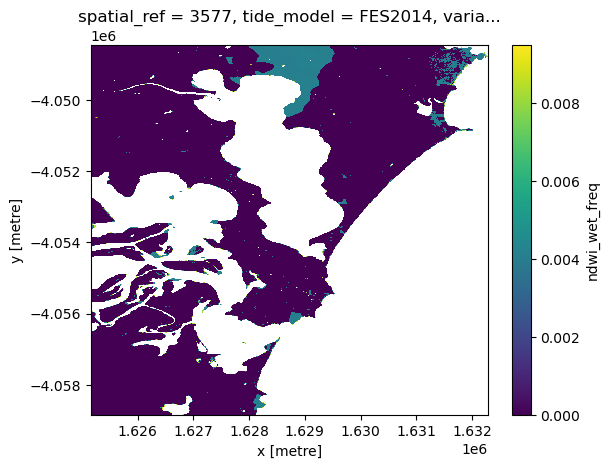

In [36]:
dry.plot()

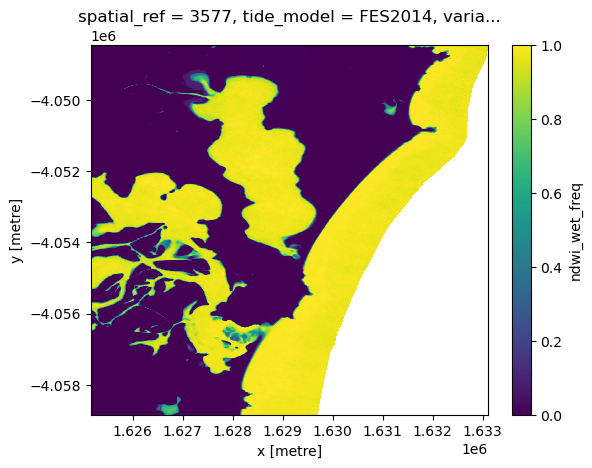

In [37]:
freq.plot()

0_Dry 1_Wet_ocean 2_Wet_inland 3_Intermittent_inland 4_Intertidal 5_Intertidal_fringe


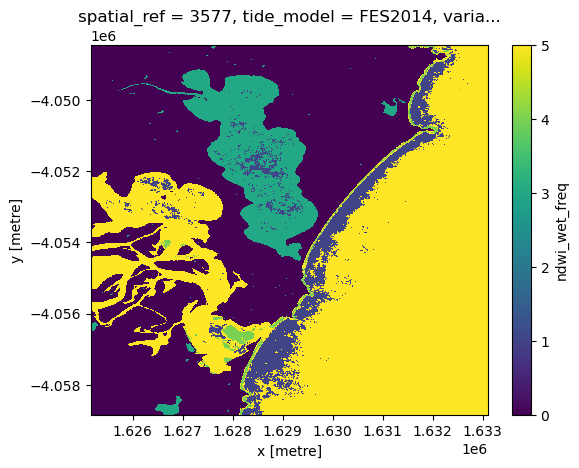

In [181]:
## upper and lower freq thresholds
upper, lower = 0.99, 0.01
'''--------------------------------------------------------------------'''
##### Identify broad classes based on wetness frequency
dry = freq.where((freq < lower), drop=True)
intermittent = freq.where((freq>=lower)&(freq<=upper),np.nan)
wet = freq.where((freq>upper),np.nan)
'''--------------------------------------------------------------------'''
##### Test 'always wet' pixels for connectivity to intertidal pixels (--> wet-ocean and wet-inland)

## Identify and relabel the pixels in 'freq' that are 'always wet (0)' and 'other (1)'.
landwater = xr.where(freq==wet,False,True)
## Drop deep-sea masked pixels
landwater = landwater.where(freq.notnull(), drop=True)

## Create the 'always wet + intertidal (0)' mask to compare against for intertidal connectivity
geodata_da = xr.where(freq>=lower,0,1)
## Drop deep-sea masked pixels
geodata_da = geodata_da.where(freq.notnull(), drop=True)

# Extract ocean pixels (value 0) from intertidal/ocean geodata_da layer,
# then erode these by 2 pixels to ensure we only
# use high certainty intertidal regions for identifying connectivity to ocean
# pixels in our satellite imagery.
ocean_da = xr.apply_ufunc(binary_erosion, geodata_da == 0, disk(2))

## Applying ocean_masking function
ocean_mask = ocean_masking(landwater, ocean_da, connectivity=1)

## distinguish wet tidal from non-tidal pixels
wet_inland = landwater.where((landwater==0) & (ocean_mask == False))#, drop=True) ## Weird artefacts when drop=True
wet_ocean = landwater.where((landwater==0) & (ocean_mask == True), drop=True)
'''--------------------------------------------------------------------'''
##### Separate intertidal
intertidal = freq.where(
                    (freq==intermittent)
                    &(corr>=0.2),
                    drop=True
                    )
'''--------------------------------------------------------------------'''
##### Separate 'intermittently wet' pixels into 'int_inland' and 'misclass_wet_ocean'
## Create the 'always wet + intertidal (0)' ds to compare against for intertidal connectivity
wet_intertidal = xr.where(freq>=lower,0,1)
# geodata_da = xr.where((freq>=lower)&(freq<=upper),0,1)

## Replace deep-sea masked pixels with 'wet' boolean (0)
wet_intertidal = wet_intertidal.where(freq.notnull(), 0)

## Create a true/false layer of intertidal pixels (1) vs everything else (0)
# # Extract intertidal pixels (value 1) then erode these by 1 pixels to ensure we only
# # use high certainty intertidal regions for identifying connectivity to wet
# # pixels in our satellite imagery.
inter = freq.where((freq>=lower)&
                      (freq<=upper)&
                      (corr>=0.2))
## Convert to true/false
inter = xr.where(freq==inter,True,False)
## Drop Nans
inter = inter.where(freq.notnull(), drop=True)
## Erode outer edge pixels
inter = xr.apply_ufunc(binary_erosion, inter == 1, disk(1))

## Applying ocean_masking function for the first of two times
intertidal_mask1 = ocean_masking(wet_intertidal, inter, connectivity=1)

## Identify and relabel the pixels in 'freq' that are 'intermittent_nontidal wet (0)' and 'other (1)'.
int_nt = xr.where(freq==intermittent_nontidal,False,True)
## Replace deep-sea masked pixels with 'wet' boolean (0)
int_nt = int_nt.where(freq.notnull(), 0)

## Applying ocean_masking function for the second time
intertidal_mask = ocean_masking(int_nt, intertidal_mask1, connectivity=1)

# ## distinguish intermittent tidal from intermittent non-tidal pixels
intermittent_inland = int_nt.where((int_nt==0) & (intertidal_mask == False))#, drop=True) ## Weird artefacts when drop=True
intertidal_fringe = int_nt.where((int_nt==0) & (intertidal_mask == True), drop=True)
'''--------------------------------------------------------------------'''
## Relabel pixels
dry = dry.where(dry.isnull(), 0)
wet_ocean = wet_ocean.where(wet_ocean.isnull(),1)
wet_inland = wet_inland.where(wet_inland.isnull(),2)
intermittent_inland = intermittent_inland.where(intermittent_inland.isnull(),3)
intertidal = intertidal.where(intertidal.isnull(),4)
intertidal_fringe = intertidal_fringe.where(intertidal_fringe.isnull(),5)

## Combine
# ds['Extents'] = (dry | wet_ocean | wet_inland)
extents = dry.combine_first(wet_ocean)
extents = extents.combine_first(wet_inland)
extents = extents.combine_first(intermittent_inland)
extents = extents.combine_first(intertidal_fringe)
extents = extents.combine_first(intertidal)

## Sanity check
# assert (ds['Extents'] ==1).all()
extents.plot(cbar_kwargs={'ticks':[0,1,2,3,4,5]})
print ('0_Dry',
       '1_Wet_ocean',
       '2_Wet_inland',
       '3_Intermittent_inland',
       '4_Intertidal',
       '5_Intertidal_fringe'
      )

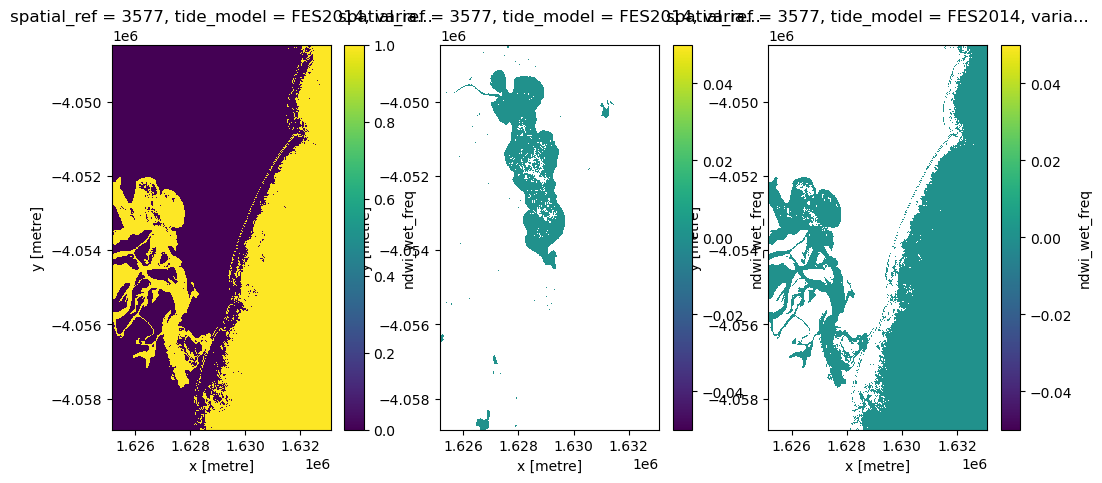

In [180]:
## Create the 'always wet + intertidal (0)' ds to compare against for intertidal connectivity
wet_intertidal = xr.where(freq>=lower,0,1)
# geodata_da = xr.where((freq>=lower)&(freq<=upper),0,1)

## Replace deep-sea masked pixels with 'wet' boolean (0)
wet_intertidal = wet_intertidal.where(freq.notnull(), 0)

## Create a true/false layer of intertidal pixels (1) vs everything else (0)
# # Extract intertidal pixels (value 1) then erode these by 1 pixels to ensure we only
# # use high certainty intertidal regions for identifying connectivity to wet
# # pixels in our satellite imagery.
inter = freq.where((freq>=lower)&
                      (freq<=upper)&
                      (corr>=0.2))
## Convert to true/false
inter = xr.where(freq==inter,True,False)
## Drop Nans
inter = inter.where(freq.notnull(), drop=True)
## Erode outer edge pixels
inter = xr.apply_ufunc(binary_erosion, inter == 1, disk(1))

## Applying ocean_masking function for the first of two times
intertidal_mask1 = ocean_masking(wet_intertidal, inter, connectivity=1)

## Identify and relabel the pixels in 'freq' that are 'intermittent_nontidal wet (0)' and 'other (1)'.
int_nt = xr.where(freq==intermittent_nontidal,False,True)
## Replace deep-sea masked pixels with 'wet' boolean (0)
int_nt = int_nt.where(freq.notnull(), 0)

## Applying ocean_masking function for the second time
intertidal_mask = ocean_masking(int_nt, intertidal_mask1, connectivity=1)

# ## distinguish intermittent tidal from intermittent non-tidal pixels
intermittent_inland = int_nt.where((int_nt==0) & (intertidal_mask == False))#, drop=True) ## Weird artefacts when drop=True
intertidal_fringe = int_nt.where((int_nt==0) & (intertidal_mask == True), drop=True)

fig,(ax1,ax2,ax3)=plt.subplots(1,3, figsize=(12,5))
intertidal_mask.plot(ax=ax1)
intermittent_inland.plot(ax=ax2)
intertidal_fringe.plot(ax=ax3)

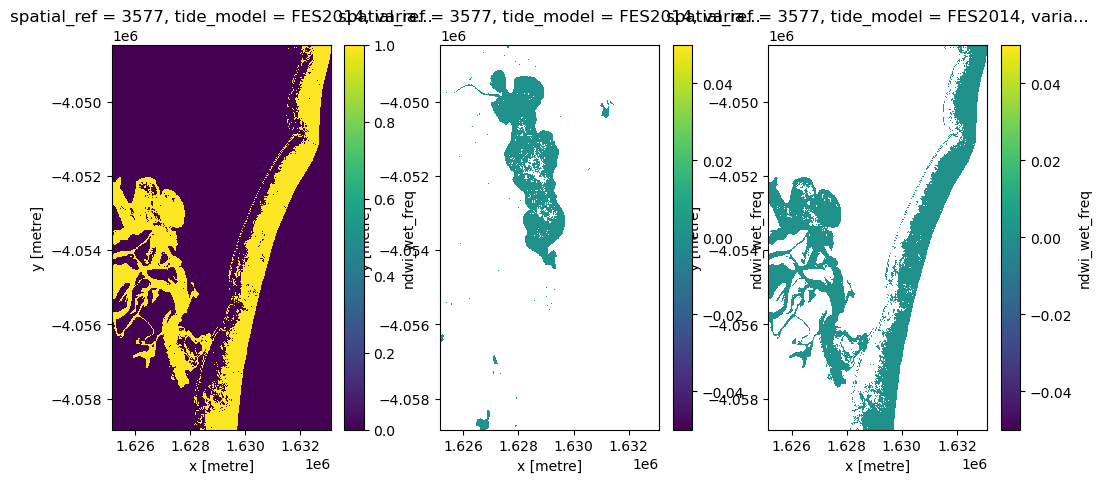

In [ ]:
# landwater.plot(cbar_kwargs={'ticks':[0,1]})
# print('0_False_Water, 1_True_Land')

# ocean_da.plot(cbar_kwargs={'ticks':[0,1]})
# print('1_Water + Intertidal, 0_Land')

### Intertidal exposure
Calculate exposure using the script function

In [ ]:
ds["exposure"], tide_cq = exposure(
    dem=ds.elevation,
    time_range=all_timerange,
    tide_model=tide_model,
    tide_model_dir=tide_model_dir,
)

### Spread and offset
Calculate the spread and high/low tide biases of input observed images as a percentage of the modelled tide heights

In [ ]:
(ds['oa_lat'], 
 ds['oa_hat'], 
 ds['oa_lot'], 
 ds['oa_hot'], 
 ds['oa_spread'], 
 ds['oa_offset_lowtide'],
 ds['oa_offset_hightide']) = bias_offset(tide_m=tide_m,
                                      tide_cq=tide_cq,
                                      extents=ds.extents,
                                      lot_hot=True,
                                      lat_hat=True)

### Tideline confidence

In [ ]:
(hightideline, 
 lowtideline, 
 tidelines_gdf) = tidal_offset_tidelines(extents=ds.extents,
                                         offset_hightide=ds.oa_offset_hightide,
                                         offset_lowtide=ds.oa_offset_lowtide,
                                         distance=250)

## Plot all layers

In [ ]:
# Inspect contents of ds before plotting
ds

In [ ]:
fig = plt.figure(figsize=(16, 18), tight_layout=True)
ax_dict = fig.subplot_mosaic(
    """
    AAAABBBBCCCC
    DDDEEEFFFGGG
    HHHIIIJJJKKK
    LLLMMM......
    """,
    height_ratios=[1, 0.8, 0.8, 0.8],
)

# label_params = dict(add_labels=False, yticks=[], xticks=[])

# Plot Elevation with hillshade
ds["elevation"].plot.imshow(
    ax=ax_dict["A"],
    cmap="viridis",
    interpolation="bilinear",
)
intertidal_hillshade(ds["elevation"], ds["extents"], vert_exag=300).plot.imshow(
    ax=ax_dict["A"],
    interpolation="bilinear",
)
ax_dict["A"].set_title("Elevation (metres AMSL)")

# Plot uncertainty
ds["elevation_uncertainty"].plot.imshow(
    ax=ax_dict["B"],
    cmap="magma",
    interpolation="bilinear",
)
ax_dict["B"].set_title("Elevation uncertainty (metres)")
ax_dict["B"].set_facecolor("#2E2E2E")

# Plot Exposure
ds["exposure"].plot.imshow(
    ax=ax_dict["C"],
    cmap="RdYlGn",
    levels=np.arange(0, 100, 1),
    add_labels=False,
    yticks=[],
)
ax_dict["C"].set_title("Exposure")

# Plot the always/sometimes/never wet extents
ds["extents"].astype(np.int16).plot.imshow(ax=ax_dict["D"])
ax_dict["D"].set_title("Wet, Dry and Intertidal extent")

# Plot the observation spread
ds["oa_spread"].plot.imshow(
    ax=ax_dict["E"],
    vmin=0,
    vmax=100,
    cmap="magma",
    cbar_kwargs={"label": "% of tidal range observed"},
)
ax_dict["E"].set_title("Observation Spread (%)")

# Plot the high-tide offset
ds["oa_offset_hightide"].plot.imshow(
    ax=ax_dict["F"],
    vmin=0,
    vmax=40,
    cmap="magma",
    cbar_kwargs={"label": "% of high tide never observed"},
)
ax_dict["F"].set_title("High-tide offset (%)")

# Plot the low-tide offset
ds["oa_offset_lowtide"].plot.imshow(
    ax=ax_dict["G"],
    vmin=0,
    vmax=40,
    cmap="magma",
    cbar_kwargs={"label": "% of low tide never observed"},
)
ax_dict["G"].set_title("Low-tide offset (%)")

# Plot the LAT
ds["oa_lat"].plot.imshow(
    ax=ax_dict["H"],
    vmin=ds["oa_lat"].min(),
    vmax=ds["oa_hat"].max(),
    add_labels=False,
)
ax_dict["H"].set_title("Lowest Astronomical Tide")

# Plot the LOT
ds["oa_lot"].plot.imshow(
    ax=ax_dict["I"], vmin=ds["oa_lat"].min(), vmax=ds["oa_hat"].max()
)
ax_dict["I"].set_title("Lowest Observed Tide")

# Plot the HAT
ds["oa_hat"].plot.imshow(
    ax=ax_dict["J"],
    vmin=ds["oa_lat"].min(),
    vmax=ds["oa_hat"].max(),
    add_labels=False,
    yticks=[],
)
ax_dict["J"].set_title("Highest Astronomical Tide")

# Plot the HOT
ds["oa_hot"].plot.imshow(
    ax=ax_dict["K"],
    vmin=ds["oa_lat"].min(),
    vmax=ds["oa_hat"].max(),
)
ax_dict["K"].set_title("Highest Observed Tide")

# Plot the high and low tidelines with respective offset
ax_dict["L"].set_title("Lowtide line and lowtide offset")
lowtideline.plot(
    column="offset_lowtide",
    legend=True,
    vmin=0,
    vmax=40,
    cmap="magma",
    ax=ax_dict["L"],
    zorder=2,
)
tidelines_gdf.loc[[0], "geometry"].plot(ax=ax_dict["L"], zorder=1)
ax_dict["L"].set_xlim(left=ds.elevation.x.min(), right=ds.elevation.x.max())
ax_dict["L"].set_ylim(bottom=ds.elevation.y.min(), top=ds.elevation.y.max())

ax_dict["M"].set_title("Hightide line and hightide offset")
hightideline.plot(
    column="offset_hightide",
    legend=True,
    vmin=0,
    vmax=40,
    cmap="magma",
    ax=ax_dict["M"],
    zorder=2,
)
tidelines_gdf.loc[[1], "geometry"].plot(ax=ax_dict["M"], zorder=1)
ax_dict["M"].set_yticks([])
ax_dict["M"].set_xlim(left=ds.elevation.x.min(), right=ds.elevation.x.max())
ax_dict["M"].set_ylim(bottom=ds.elevation.y.min(), top=ds.elevation.y.max())

# Remove axis labels
for label, ax in ax_dict.items():
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylabel("")
    ax.set_xlabel("")

## Export layers

In [ ]:
# If a custom area was selected from the map, use "testing" for output files
if isinstance(study_area, Geometry):
    study_area = 'testing'
    
# Create output folder. If it doesn't exist, create it
output_dir = f"data/interim/{study_area}"
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# Export figure
fig.savefig(f"data/figures/{study_area}_{start_date}_{end_date}.png")

In [ ]:
# Save rasters as GeoTIFFs
export_intertidal_rasters(ds, prefix=f"{output_dir}/{study_area}_{start_date}_{end_date}")
export_intertidal_rasters(ds_aux, prefix=f"{output_dir}/{study_area}_{start_date}_{end_date}_debug")

In [ ]:
# Export vector files
hightideline.to_crs("EPSG:4326").to_file(f"{output_dir}/{study_area}_{start_date}_{end_date}_offset_hightide.geojson")
lowtideline.to_crs("EPSG:4326").to_file(f"{output_dir}/{study_area}_{start_date}_{end_date}_offset_lowtide.geojson")
tidelines_gdf.to_crs("EPSG:4326").to_file(f"{output_dir}/{study_area}_{start_date}_{end_date}_tidelines_highlow.geojson")